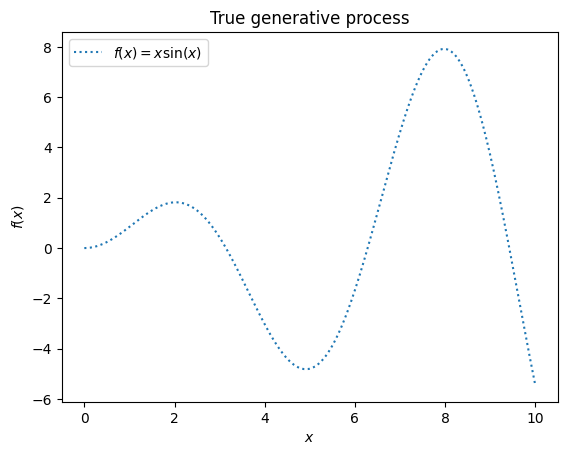

In [1]:
import numpy as np

X = np.linspace(start=0, stop=10, num=5_000).reshape(-1, 1)
X_test = np.linspace(start=-5, stop=15, num=2_000).reshape(-1, 1)
y = np.squeeze(X * np.sin(X))

import matplotlib.pyplot as plt

plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("True generative process")

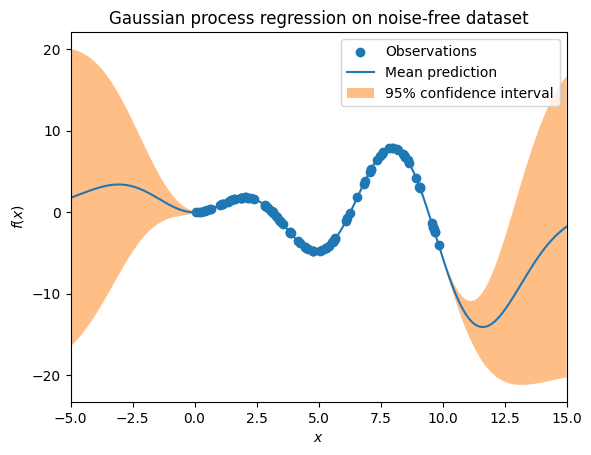

In [15]:
rng = np.random.RandomState(2)
training_indices = rng.choice(np.arange(y.size), size=100, replace=False)
X_train, y_train = X[training_indices], y[training_indices]

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))


gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, alpha=0.01)
gaussian_process.fit(X_train, y_train)
gaussian_process.kernel_

mean_prediction, std_prediction = gaussian_process.predict(X_test, return_std=True)

#plt.plot(X_test, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.plot(X_test, mean_prediction, label="Mean prediction")
plt.fill_between(
    X_test.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.xlim(-5,15)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on noise-free dataset")

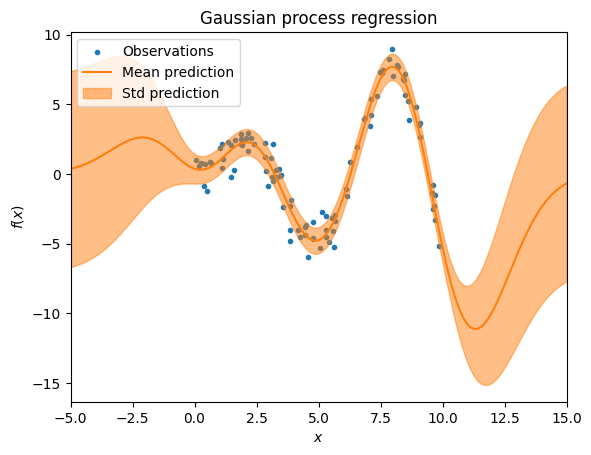

In [16]:
noise_std = 1
y_train_noisy = y_train + rng.normal(loc=0.0, scale=noise_std, size=y_train.shape)

kernel = kernel + WhiteKernel(
    noise_level=noise_std**2, noise_level_bounds=(1e-5, 1e1)
)
gaussian_process = GaussianProcessRegressor(
    kernel=kernel, n_restarts_optimizer=9
)
gaussian_process.fit(X_train, y_train_noisy)
mean_prediction, std_prediction = gaussian_process.predict(X_test, return_std=True)

#plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.scatter(
    X_train,
    y_train_noisy,
    linestyle="None",
    color="tab:blue",
    marker=".",
    label="Observations",
)
plt.plot(X_test, mean_prediction, label="Mean prediction", color="tab:orange")
plt.fill_between(
    X_test.ravel(),
    mean_prediction - std_prediction,
    mean_prediction + std_prediction,
    color="tab:orange",
    alpha=0.5,
    label=r"Std prediction",
)
plt.xlim(-5,15)

plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression")

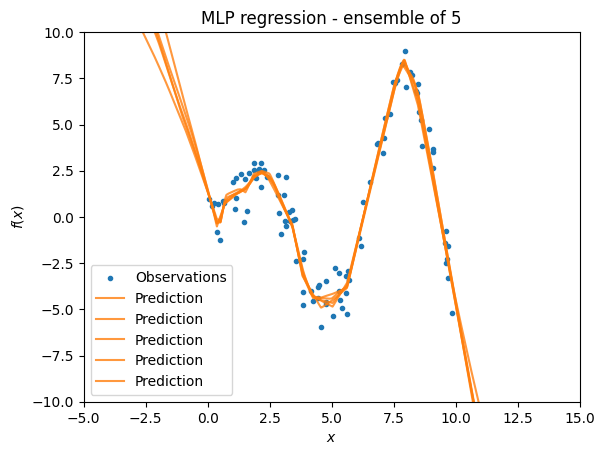

In [17]:
from sklearn.neural_network import MLPRegressor

num_networks = 5
regr = [None] * num_networks
mean_prediction = [None] * num_networks

for n in range(num_networks):

    regr[n] = MLPRegressor(hidden_layer_sizes=(100,100,100), random_state=n, max_iter=10000).fit(X_train, y_train_noisy)
    mean_prediction[n] = regr[n].predict(X_test)

plt.scatter(
    X_train,
    y_train_noisy,
    linestyle="None",
    color="tab:blue",
    marker=".",
    label="Observations",
)
for n in range(num_networks):
    plt.plot(X_test, mean_prediction[n], label="Prediction", color="tab:orange", alpha=0.8)
plt.xlim(-5,15)
plt.ylim(-10,10)

plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title(f"MLP regression - ensemble of {num_networks}")